# Análise, Modelagem e Avaliação: Churn Prediction

Este notebook documenta o processo de construção de um modelo de Classificação Binária para prever o **cancelamento de clientes (Churn)** em uma empresa de telecomunicações. O objetivo principal é não apenas obter um modelo preditivo, mas também identificar os **principais fatores** que levam ao cancelamento, fornecendo *insights* acionáveis para a retenção de clientes.

## Carregamento, Inspeção e Limpeza Inicial do Dataset

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = "../data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Formato: {df.shape}")
    print(df.info())
    display(df.head(5))
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em {DATA_PATH}. Verifique o caminho.")

Formato: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Limpeza e Tratamento da Coluna 'TotalCharges'

A inspeção inicial revelou que a coluna `TotalCharges`, que representa um valor monetário e deveria ser numérica, está incorretamente classificada como `object` (string). Isso geralmente indica a presença de caracteres não numéricos. Faremos a conversão dessa coluna para `float` e, ao mesmo tempo, identificaremos quantos valores inválidos existem para posterior tratamento.

In [2]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
print(f"Tipo da coluna 'TotalCharges': {df['TotalCharges'].dtype}")
print(f"Valores nulos na coluna 'TotalCharges': {df['TotalCharges'].isnull().sum()}")

Tipo da coluna 'TotalCharges': float64
Valores nulos na coluna 'TotalCharges': 11


In [3]:
print(f"Índice dos valores nulos na coluna 'TotalCharges': {np.where(df['TotalCharges'].isnull())[0].tolist()}")

Índice dos valores nulos na coluna 'TotalCharges': [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


Com isso, a coluna `TotalCharges` agora está corretamente tipada como `float64` e, além disso, identificou-se um total de **11 valores nulos (`NaN`)** restantes. 

---

### Tratamento de Valores Nulos e Remoção da Coluna Identificadora

Agora que isolamos os valores nulos, é necessário que os tratemos antes de partir para o treinamento do modelo. Apesar de serem poucos nulos, optaremos por fazer a **imputação pela mediana**, preservando assim todos os dados.
Podemos também fazer a remoção da coluna `customerID`, tendo em vista que ela não agrega valor preditivo.

In [4]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df = df.drop('customerID', axis = 1)

print(f"Total de valores nulos no DF: {df.isnull().sum()}")
print(f"Novo formato do DF: {df.shape}")

Total de valores nulos no DF: gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Novo formato do DF: (7043, 20)


## Análise Exploratória de Dados
### Análise da Variável *Target*
O objetivo agora é entender a variável *target* (`Churn`) e como as *features* se relacionam com ela.

In [5]:
print(f"Distribuição da variável alvo: {df['Churn'].value_counts(normalize=True)}")

Distribuição da variável alvo: Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


Temos um desbalanceamento:

* Clientes que **não cancelaram** (`No`): 73.46%
* Clientes que **cancelaram** (`yes`): 26.54%

Quase três quartos dos clientes não cancelam. Se criarmos um modelo que apenas prevê "Não" para todos, teremos uma Acurácia de $≈73.46$%. Isso significa que a Acurácia (**Accuracy**) será uma métrica enganosa. Nosso foco terá que ser em **Recall**, **Precisão** e **AUC**.

---

### Pré-processamento e Feature Engineering
Antes de prosseguirmos para a visualização, é necessário finalizar o tratamento dos dados, focando em transformar as *strings* em números para a modelagem.
* Converteremos a variável alvo `Churn` de *object* (`yes`, `no`) para binário (`int`: $0$ ou $1$)
* Identificaremos e trataremos as colunas binárias que ainda estão como *object*, também convertendo-as para $0$ ou $1$.
* Por fim, identificaremos e trataremos as colunas categóricas que possuem mais de duas classes, utilizando o `pd.get_dummies()`.

In [7]:
# Codificação da variável alvo
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"\nDistribuição da variável alvo após codificação:\n {df['Churn'].value_counts(normalize=True)}", )

# Codificação das colunas binárias
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

def encode_binary_columns(df: pd.DataFrame):
    """
    Detecta colunas binárias que contenham apenas 'yes'/'no' (qualquer capitalização)
    e as converte para 1/0.
    
    Retorna:
      - df_encoded: DataFrame com as colunas convertidas
      - binary_cols: lista das colunas convertidas
    """
    df_encoded = df.copy()

    for col in df.columns:
        # Pega valores únicos em minúsculas
        unique_vals = df[col].astype(str).str.lower().unique()
        
        # Verifica se a coluna contém exatamente 'yes' e 'no'
        if set(unique_vals) == {'yes', 'no'}:
            df_encoded[col] = df[col].str.lower().map({'yes': 1, 'no': 0})

    return df_encoded

df = encode_binary_columns(df)

# Codificação das colunas categóricas
categorical_cols = df.select_dtypes(include = ['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print(f"Novo formato do DataFrame: {df.shape}")
display(df.head())


Distribuição da variável alvo após codificação:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Novo formato do DataFrame: (7043, 31)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


### Análise de Correlação e Impacto nas Features
Vamos analisar a **correlação** através da **Matriz de Correlação** para identificarmos a importância das *features*.

InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService                             0.011942
gender                                   0.008612
MultipleLines_No phone service          -0.011942
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226
Contract_One year                       -0.177820


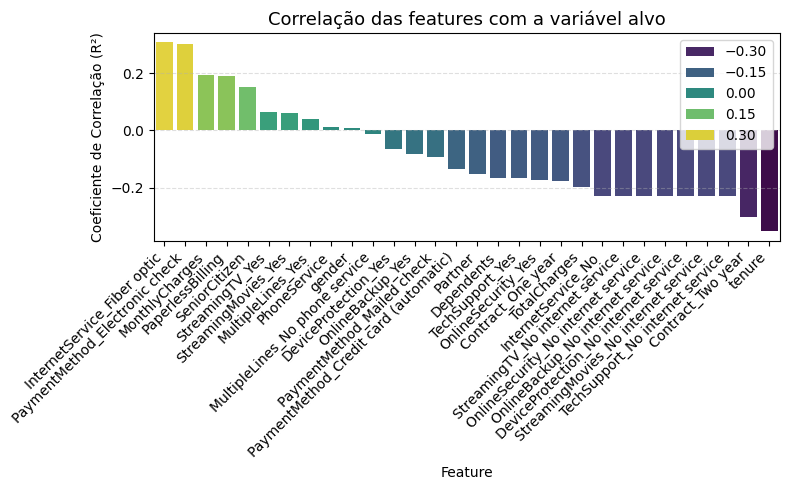

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

corr_target = corr_matrix['Churn'].drop('Churn').sort_values(ascending = False)

print(corr_target)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr_target.index, y=corr_target.values, palette='viridis', hue=corr_target.values)
plt.title('Correlação das features com a variável alvo', fontsize=13)
plt.ylabel('Coeficiente de Correlação (R²)')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Temos então a visualização das correlações de cada *feature* com a variável alvo. Destacando as 3 mais fortes:

|*Feature*|Correlação|*Insight*|
|:---:|:---:|:---:|
|**tenure**|$≈-0.35$ (**Negativa**)|Quanto maior o tempo de contrato, **menor** a chance de cancelamento. O *Churn* é um problema de clientes novos.|
|**InternetService_Fiber optic**|$≈0.31$ (**Positiva**)|Clientes que usam **Fibra Óptica** têm uma chance **maior** de cancelar. Isso pode indicar problemas de qualidade/confiabilidade nesse serviço ou preços altos.|
|**Contract_Two year**|$≈-0.30$ (**Negativa**)|Ter um contrato de longo prazo é o **maior fator de retenção**. Quanto maior o compromisso, menor o *churn*.|
|**PaymentMethod_Electronic check**|$≈0.30$ (**Positiva**)|Clientes que pagam via Cheque Eletrônico têm uma chance muito maior de cancelar. Pode indicar insatisfação imediata com a cobrança ou ser um método de pagamento associado a clientes de curto prazo.|
|**InternetService_No**|$≈-0.23$ (**Negativa**)|Clientes que não possuem serviço de internet têm uma chance **menor** de cancelar. Isso sugere que os serviços de internet da empresa são uma fonte da insatisfação.|

A análise das 5 primeiras *features* sugere que o problema de **Churn** está relacionado aos **serviços de internet** (`InternetService_Fiber optic` e `InternetService_No`), além no tempo de contrato.

---

## Modelagem Preditiva e Baseline
### Separação de Dados e Regressão Logística
Dividiremos o DataFrame primeiramente em *features* (`X`) e *target* (`y`), em seguida utilizaremos a função `train_test_split`, do *Scikit-learn*, para separar `X` e `y` em conjuntos de treino e teste. Com isso, será possível treinar o primeiro modelo de **Regressão Logística** (`LogisticRegression`), a partir do qual extrairemos as métricas que nos servirão como ***Baseline***.

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

AUC-ROC:
 0.8422


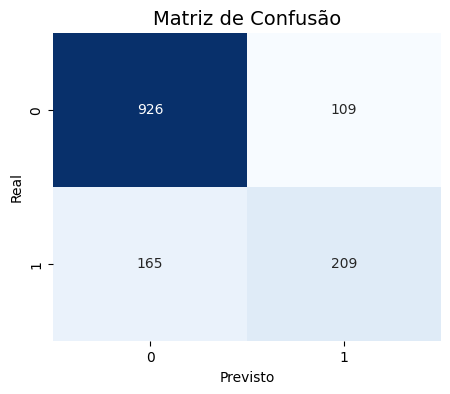

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Separação dos dados
X = df.drop(columns='Churn')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

# Instanciando e treinando o modelo
lr_model = LogisticRegression(max_iter=2500)
lr_model.fit(X_train, y_train)

# Previsões e Métricas
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:,1] # Previsão de probabilidades para o AUC

cm = confusion_matrix(y_test, y_pred)
#print(f"Matriz de Confusão: \n {confusion_matrix(y_test, y_pred)}")

print(f"Relatório de Classificação: \n {classification_report(y_test, y_pred)}")

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC:\n {auc_score:.4f}")

# Gráfico da matriz de confusão
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão', fontsize=14)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()